Building trajectories: 100%|█████████████████████████████████████████████| 2200/2200 [00:02<00:00, 880.94it/s]


Trajectories kept: 2200
Points: (1700787, 20) (213137, 20) (204458, 20)
Device: cuda


Training: 100%|██████████████████| 250/250 [1:30:24<00:00, 21.70s/it, lpinn=0, train=5.938e-05, val=1.545e-04]


[TEST] MSE = 1.4338e-04


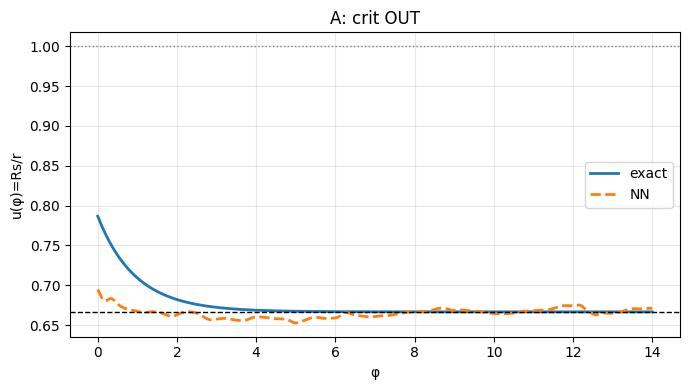

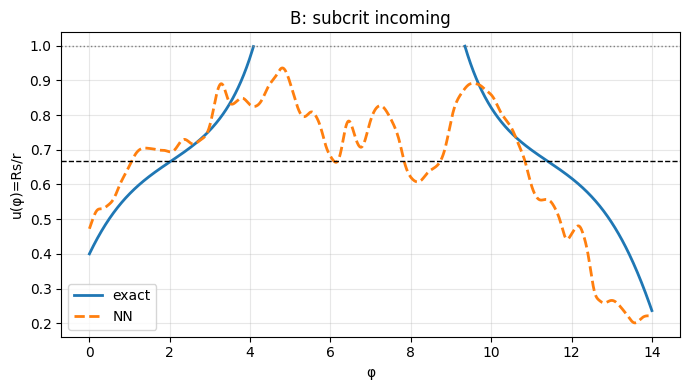

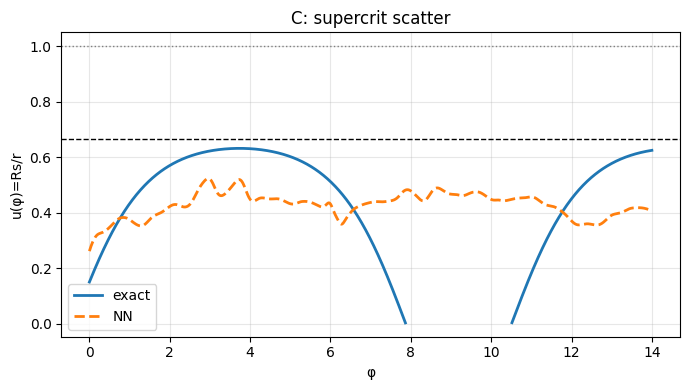

In [1]:
"""
Orbit emulator for Schwarzschild photon orbits
----------------------------------------------
Unified script with improvements:

✅ Vectorized ellipj (much faster dataset gen)
✅ Train/val/test split by TRAJECTORY (no leakage)
✅ Cleaner features: phi_norm in [0,1], u0, delta_b=(b/bc-1)
✅ Optional PINN-style residual regularization (toggle lambda_pinn)
✅ Fixed duplicated / unreachable code in train_model
✅ (Optional) case flag feature A/B/C

Notes:
- This code assumes the ODE in your convention is:
      u'' + u = (3/2) u^2
  (which matches the standard null-geodesic equation when u = Rs/r and Rs=2M).
  If your convention differs, adjust `ode_residual()`.

Author: adapted to your code style
"""

import numpy as np
from scipy.special import ellipj, ellipk
from scipy.optimize import brentq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm import trange

# ============================================================
# 1) Analytic unified solution u(phi; Rs, b, u0)
# ============================================================

def bcrit(Rs=1.0):
    return (3*np.sqrt(3)/2.0)*Rs

def _sech2(x):
    c = np.cosh(x)
    return 1.0/(c*c)

def _csch2(x):
    s = np.sinh(x)
    s = np.where(np.abs(s) < 1e-15, np.sign(s)*1e-15, s)
    return 1.0/(s*s)

# ---- Case A: b = bcrit ----
def _alpha_from_ic_crit(mode, phi0, u0):
    if mode == "in":   # 0<u<=2/3
        val = np.clip(2/3 - float(u0), 1e-12, 2/3 - 1e-12)
        y = np.arccosh(1.0/np.sqrt(val))
        return phi0 - 2.0*y
    elif mode == "out":  # 2/3<=u<1
        val = max(float(u0) - 2/3, 1e-12)
        y = np.arcsinh(1.0/np.sqrt(val))
        return phi0 - 2.0*y
    else:
        raise ValueError("mode debe ser 'in' o 'out'.")

def _u_phi_crit(phi, u0, phi0=0.0):
    phi = np.asarray(phi, dtype=float)
    if np.isclose(u0, 2/3, atol=1e-14):
        u = np.full_like(phi, 2/3, dtype=float)
        return u, {"case":"A","mode":"circular"}

    mode = "in" if (u0 < 2/3) else "out"
    alpha = _alpha_from_ic_crit(mode, phi0, u0)
    y = 0.5*(phi - alpha)

    if mode == "in":
        u = (2/3) - _sech2(y)
        mask = (u > 0.0)
    else:
        u = (2/3) + _csch2(y)
        mask = (u <= 1.0)

    u = np.where(np.isfinite(u) & mask, u, np.nan)
    return u, {"case":"A","mode":mode,"alpha":alpha}

# ---- Case B: b < bcrit ----
def _roots_re_u2(xi):
    xi23, xi_23 = xi**(2/3.0), xi**(-2/3.0)
    return (1/3.0)*(1 + 0.5*(xi23 + xi_23))

def _pqk_from_xi(xi):
    T = xi**(-4/3.0) + xi**(4/3.0) + 1.0
    S = xi**(-2/3.0) + xi**(2/3.0) - 1.0
    p = (1/np.sqrt(3))*np.sqrt(T) + (1/3)*S
    q = (1/np.sqrt(3))*np.sqrt(T) - (1/3)*S
    Re_u2 = _roots_re_u2(xi)
    k = np.sqrt((Re_u2 + p) / (p + q))
    spsi = np.sqrt((p + q)/2.0)
    return p, q, k, spsi

def _xi_from_b_lt(b, Rs=1.0):
    x = bcrit(Rs)/b
    if x <= 1.0:
        raise ValueError("Se requiere b<bcrit (x>1).")
    return x - np.sqrt(x*x - 1.0)

def _arccn(C, k):
    m = k*k
    K = ellipk(m)
    C = float(np.clip(C, -1.0, 1.0))

    def Ffun(u):
        # cn(u,m) is ellipj(u,m)[1]
        return ellipj(u, m)[1] - C

    a, b = (0.0, K) if C >= 0.0 else (K, 2*K)
    fa, fb = Ffun(a), Ffun(b)
    if abs(fa) < 1e-12: return a
    if abs(fb) < 1e-12: return b
    return brentq(Ffun, a, b)

def _u_phi_B(phi, u0, b, Rs=1.0, phi0=0.0, branch=None):
    if branch is None:
        branch = "incoming" if (u0 < 2/3) else "outgoing"

    xi = _xi_from_b_lt(b, Rs)
    p, q, k, spsi = _pqk_from_xi(xi)
    s = +1.0 if branch == "incoming" else -1.0

    C0  = (q - u0) / (s*(u0 + p))
    C0  = float(np.clip(C0, -1.0, 1.0))
    psi0 = _arccn(C0, k)

    m = k*k
    phi = np.asarray(phi, dtype=float)
    psi = spsi*(phi - phi0) + psi0

    # ✅ vectorized ellipj
    sn, cn, dn, ph = ellipj(psi, m)
    u = (q - s*p*cn) / (1.0 + s*cn)

    u = np.where((u>0.0) & (u<=1.0), u, np.nan)
    return u, {"case":"B","branch":branch,"p":p,"q":q,"k":k,"spsi":spsi}

# ---- Case C: b > bcrit ----
def _cubic_roots_from_b(b, Rs=1.0):
    c0 = (Rs/b)**2
    roots = np.roots([1.0, -1.0, 0.0, c0])
    roots = np.real_if_close(roots[np.isreal(roots)], tol=1e-10)
    roots.sort()
    if len(roots) != 3:
        raise ValueError("Se esperaban 3 raíces reales (¿b <= bcrit?).")
    return roots[0], roots[1], roots[2]

def _arcsn(S, k):
    S = float(np.clip(S, 0.0, 1.0))
    m = k*k
    K = ellipk(m)
    if np.isclose(S, 0.0, atol=1e-14): return 0.0
    if np.isclose(S, 1.0, atol=1e-14): return K

    def f(u): return ellipj(u, m)[0] - S
    return brentq(f, 0.0, K)

def _u_phi_C(phi, u0, b, Rs=1.0, phi0=0.0, region=None):
    u1, u2, u3 = _cubic_roots_from_b(b, Rs)
    k   = np.sqrt((u2 - u1) / (u3 - u1))
    sps = 0.5 * np.sqrt(u3 - u1)

    if region is None:
        if 0.0 < u0 <= u2: region = 'scatter'
        elif u0 >= u3 and u0 <= 1.0: region = 'inner'
        else:
            raise ValueError(f"u0={u0} fuera de regiones físicas: (0,u2] o [u3,1].")

    phi = np.asarray(phi, dtype=float)
    psi = sps*(phi - phi0)
    m = k*k

    if region == 'scatter':
        S0 = np.sqrt(np.clip((u0 - u1) / (u2 - u1), 0.0, 1.0))
        alpha = -_arcsn(S0, k)
        sn, cn, dn, ph = ellipj(psi - alpha, m)  # ✅ vectorized
        u = u1 + (u2 - u1)*sn**2
        mask = (u>0.0) & (u<=u2 + 1e-12)

    elif region == 'inner':
        S0 = np.sqrt(np.clip((u3 - u1) / (u0 - u1), 0.0, 1.0))
        alpha = -_arcsn(S0, k)
        sn, cn, dn, ph = ellipj(psi - alpha, m)  # ✅ vectorized
        sn2 = sn**2
        sn2 = np.where(sn2 < 1e-14, np.nan, sn2)
        u = u1 + (u3 - u1)/sn2
        mask = (u>=u3 - 1e-12) & (u<=1.0 + 1e-12)

    else:
        raise ValueError("region debe ser 'scatter' o 'inner'.")

    u = np.where(np.isfinite(u) & mask, u, np.nan)
    return u, {"case":"C","region":region,"u1":u1,"u2":u2,"u3":u3,"k":k,"sps":sps}

def u_phi_general(phi, Rs, b, u0, phi0=0.0, branch=None, region=None):
    bc = bcrit(Rs)
    if np.isclose(b, bc, rtol=1e-12, atol=1e-14):
        u, meta = _u_phi_crit(phi, u0, phi0=phi0)
        meta.update({"b_over_bc":1.0})
        return u, meta
    elif b < bc:
        u, meta = _u_phi_B(phi, u0, b, Rs=Rs, phi0=phi0, branch=branch)
        meta.update({"b_over_bc":b/bc})
        return u, meta
    else:
        u, meta = _u_phi_C(phi, u0, b, Rs=Rs, phi0=phi0, region=region)
        meta.update({"b_over_bc":b/bc})
        return u, meta

# ============================================================
# 2) Sampling helpers
# ============================================================

def sample_b(Rs=1.0, rng=None):
    """
    Sample b across the three regimes, oversampling near bcrit.
    Returns (b, tag) where tag in {'A','B','C'}.
    """
    rng = np.random.default_rng() if rng is None else rng
    bc = bcrit(Rs)

    r = rng.random()
    if r < 0.30:
        return bc, 'A'
    elif r < 0.30 + 0.35:
        eps = 10**rng.uniform(-6, -0.7)
        return bc*(1.0 - eps), 'B'
    else:
        eps = 10**rng.uniform(-6, -0.7)
        return bc*(1.0 + eps), 'C'

def sample_u0_for_case(b, tag, Rs=1.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng

    if tag == 'A':
        p = rng.random()
        if p < 0.25:
            return 2/3 - rng.uniform(0.05, 0.25)
        elif p < 0.50:
            return 2/3 + rng.uniform(0.05, 0.25)
        elif p < 0.75:
            return 2/3 + rng.choice([-1, +1])*10**rng.uniform(-6, -2)
        else:
            return 2/3

    elif tag == 'B':
        if rng.random() < 0.6:
            return rng.uniform(0.02, 0.60)
        else:
            return rng.uniform(0.70, 0.95)

    else:
        u1, u2, u3 = _cubic_roots_from_b(b, Rs)
        if rng.random() < 0.6:
            hi = max(min(u2*0.95, 0.6), 0.05)
            return rng.uniform(0.05, hi)
        else:
            lo = min(max(u3+0.01, 0.75), 0.98)
            return rng.uniform(lo, 0.98)

def case_flag(tag):
    # optional one-hot-ish scalar encoding
    # A->0, B->1, C->2
    return {"A":0.0,"B":1.0,"C":2.0}[tag]

# ============================================================
# 3) Dataset: build TRAJECTORY blocks + split by trajectory
# ============================================================

def positional_encoding(phi, K=8):
    # phi: shape (T,)
    pe = []
    for k in range(1, K+1):
        pe.append(np.sin(k*phi))
        pe.append(np.cos(k*phi))
    return np.stack(pe, axis=1).astype(np.float32)  # (T, 2K)

def build_trajectory_dataset(
    N_traj=2000,
    Rs=1.0,
    phi_max=16.0,
    T=1024,
    Kpe=8,
    mask_physical=True,
    add_case_feature=True,
    rng=None,
):
    """
    Returns:
      X_traj: list of (Ti, D) arrays (one per trajectory)
      y_traj: list of (Ti, 1) arrays
      meta_traj: list of dicts with b,u0,tag,...

    Features used:
      phi_norm = phi/phi_max
      u0
      delta_b  = b/bc - 1
      [optional] case_code in {0,1,2}
      PE(phi) with K harmonics
    """
    rng = np.random.default_rng() if rng is None else rng
    bc = bcrit(Rs)

    phi = np.linspace(1e-4, phi_max, T).astype(np.float32)
    phi_norm = (phi / phi_max).astype(np.float32)
    pe = positional_encoding(phi, K=Kpe)

    X_list, y_list, m_list = [], [], []

    for _ in trange(N_traj, desc="Building trajectories", ncols=110):
        b, tag = sample_b(Rs, rng)
        u0 = sample_u0_for_case(b, tag, Rs, rng)

        try:
            u, meta = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0)
        except Exception:
            continue

        if mask_physical:
            mask = np.isfinite(u) & (u > 0.0) & (u <= 1.0)
        else:
            mask = np.isfinite(u)

        if mask.sum() < 16:
            continue

        # base scalars
        db = (b/bc - 1.0).astype(np.float64) if hasattr(b/bc - 1.0, "astype") else (b/bc - 1.0)
        db = np.float32(db)
        u0f = np.float32(u0)

        # assemble X per valid point
        feats = [phi_norm[mask][:,None],
                 np.full((mask.sum(),1), u0f, dtype=np.float32),
                 np.full((mask.sum(),1), db,  dtype=np.float32)]

        if add_case_feature:
            cc = np.float32(case_flag(tag))
            feats.append(np.full((mask.sum(),1), cc, dtype=np.float32))

        feats.append(pe[mask])

        X_block = np.concatenate(feats, axis=1).astype(np.float32)
        y_block = u[mask].astype(np.float32)[:,None]

        X_list.append(X_block)
        y_list.append(y_block)

        info = {"b":float(b), "u0":float(u0), "tag":tag}
        info.update(meta)
        m_list.append(info)

    return X_list, y_list, m_list

def split_by_trajectory(X_list, y_list, m_list, seed=123, frac=(0.8,0.1,0.1)):
    n = len(X_list)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)

    n_tr = int(frac[0]*n)
    n_va = int(frac[1]*n)
    idx_tr = idx[:n_tr]
    idx_va = idx[n_tr:n_tr+n_va]
    idx_te = idx[n_tr+n_va:]

    def gather(idxs):
        X = np.concatenate([X_list[i] for i in idxs], axis=0)
        y = np.concatenate([y_list[i] for i in idxs], axis=0)
        return X, y

    Xtr, ytr = gather(idx_tr)
    Xva, yva = gather(idx_va)
    Xte, yte = gather(idx_te)

    return (Xtr, ytr), (Xva, yva), (Xte, yte), (idx_tr, idx_va, idx_te)

# ============================================================
# 4) Model + optional PINN residual
# ============================================================

class OrbitMLP(nn.Module):
    def __init__(self, in_dim, width=192, depth=5):
        super().__init__()
        layers = []
        dims = [in_dim] + [width]*depth + [1]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def ode_residual(u, phi, phi_max=16.0):
    """
    Residual of u'' + u - (3/2)u^2 = 0 with derivatives wrt physical phi.

    Inputs:
      u: (N,1) predicted u
      phi: (N,1) phi_norm in [0,1]  (the first feature in our X)
    """
    # Convert d/d(phi_norm) to d/dphi:
    # phi_norm = phi/phi_max -> d/dphi = (1/phi_max) d/dphi_norm
    # so u_phi  = (1/phi_max) u_n
    # u_phiphi = (1/phi_max^2) u_nn
    u_n = torch.autograd.grad(
        u, phi, grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True
    )[0]
    u_nn = torch.autograd.grad(
        u_n, phi, grad_outputs=torch.ones_like(u_n),
        create_graph=True, retain_graph=True
    )[0]
    u_phiphi = u_nn / (phi_max*phi_max)

    return u_phiphi + u - 1.5*u*u

def train_model(
    Xtr, ytr, Xva, yva, Xte, yte,
    epochs=200,
    batch=8192,
    lr=2e-3,
    lambda_pinn=0.0,   # set e.g. 1e-3 to activate
    phi_max=16.0,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.float32)
    Xva_t = torch.tensor(Xva, dtype=torch.float32)
    yva_t = torch.tensor(yva, dtype=torch.float32)
    Xte_t = torch.tensor(Xte, dtype=torch.float32)
    yte_t = torch.tensor(yte, dtype=torch.float32)

    dl_tr = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch, shuffle=True, pin_memory=True)
    dl_va = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch, shuffle=False, pin_memory=True)
    dl_te = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=batch, shuffle=False, pin_memory=True)

    model = OrbitMLP(in_dim=Xtr.shape[1], width=192, depth=5).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    tr_hist, va_hist = [], []

    bar = trange(1, epochs+1, desc="Training", ncols=110)
    for ep in bar:
        # ---- train
        model.train()
        run, ns = 0.0, 0

        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device)

            opt.zero_grad(set_to_none=True)

            if lambda_pinn > 0.0:
                xb.requires_grad_(True)

            pred = model(xb)
            loss_data = F.mse_loss(pred, yb)

            if lambda_pinn > 0.0:
                # phi_norm is first column
                phi = xb[:, [0]]
                res = ode_residual(pred, phi, phi_max=phi_max)
                loss_pinn = torch.mean(res*res)
                loss = loss_data + lambda_pinn*loss_pinn
            else:
                loss = loss_data

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            run += loss_data.item()*len(xb)  # report data loss only
            ns += len(xb)

        tr_loss = run / ns

        # ---- val
        model.eval()
        run, ns = 0.0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
                run += loss.item()*len(xb)
                ns += len(xb)

        va_loss = run / ns
        tr_hist.append(tr_loss)
        va_hist.append(va_loss)
        sched.step()

        bar.set_postfix(train=f"{tr_loss:.3e}", val=f"{va_loss:.3e}", lpinn=f"{lambda_pinn:g}")

    # ---- test
    model.eval()
    with torch.no_grad():
        xb = Xte_t.to(device)
        yb = yte_t.to(device)
        mse = F.mse_loss(model(xb), yb).item()
    print(f"[TEST] MSE = {mse:.4e}")

    return model, (tr_hist, va_hist), mse

# ============================================================
# 5) Quick evaluation on full trajectory (no leakage)
# ============================================================

def predict_trajectory(model, phi, u0, b, Rs=1.0, phi_max=16.0, Kpe=8, add_case_feature=True):
    bc = bcrit(Rs)

    phi = np.asarray(phi, dtype=np.float32)
    phi_norm = (phi / phi_max).astype(np.float32)
    pe = positional_encoding(phi, K=Kpe)

    db = np.float32(b/bc - 1.0)
    u0f = np.float32(u0)

    feats = [phi_norm[:,None],
             np.full((len(phi),1), u0f, dtype=np.float32),
             np.full((len(phi),1), db,  dtype=np.float32)]
    if add_case_feature:
        # you can pass unknown here; set to -1 to indicate "unknown"
        feats.append(np.full((len(phi),1), np.float32(-1.0), dtype=np.float32))
    feats.append(pe)

    X = np.concatenate(feats, axis=1).astype(np.float32)

    device = next(model.parameters()).device
    with torch.no_grad():
        up = model(torch.tensor(X, device=device)).cpu().numpy().squeeze()
    return up

# ============================================================
# 6) Main
# ============================================================

if __name__ == "__main__":
    # ---- Build dataset by trajectories
    Rs = 1.0
    phi_max = 16.0

    X_list, y_list, m_list = build_trajectory_dataset(
        N_traj=2200,
        Rs=Rs,
        phi_max=phi_max,
        T=1200,
        Kpe=8,
        mask_physical=True,
        add_case_feature=True,
    )
    print(f"Trajectories kept: {len(X_list)}")

    (Xtr, ytr), (Xva, yva), (Xte, yte), splits = split_by_trajectory(
        X_list, y_list, m_list, seed=123, frac=(0.8,0.1,0.1)
    )
    print("Points:", Xtr.shape, Xva.shape, Xte.shape)

    # ---- Train
    model, hist, mse = train_model(
        Xtr, ytr, Xva, yva, Xte, yte,
        epochs=250,
        batch=8192,
        lr=2e-3,
        lambda_pinn=0.0,   # try 1e-4 or 1e-3 once supervised is stable
        phi_max=phi_max,
    )

    # ---- Quick qualitative test
    import matplotlib.pyplot as plt

    bc = bcrit(Rs)
    phi = np.linspace(1e-4, 14.0, 1400).astype(np.float32)

    tests = [
        ("A: crit OUT", bc, 2/3+0.12),
        ("B: subcrit incoming", 0.98*bc, 0.40),
        ("C: supercrit scatter", 1.004*bc, 0.15),
    ]

    for name, b, u0 in tests:
        u_true, meta = u_phi_general(phi, Rs=Rs, b=b, u0=u0)
        u_pred = predict_trajectory(model, phi, u0, b, Rs=Rs, phi_max=phi_max, Kpe=8, add_case_feature=True)

        plt.figure(figsize=(7,4))
        plt.plot(phi, u_true, label="exact", lw=2)
        plt.plot(phi, u_pred, "--", label="NN", lw=2)
        plt.axhline(2/3, ls="--", c="k", lw=1)
        plt.axhline(1.0, ls=":",  c="gray", lw=1)
        plt.xlabel("φ"); plt.ylabel("u(φ)=Rs/r"); plt.title(name)
        plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout()
        plt.show()


---

In [5]:
# ============================================================
# Orbit emulator for Schwarzschild photon orbits (self-contained)
# - Analytic u(phi; Rs,b,u0)  (cases A/B/C)
# - Dataset builder (your original feature style)
# - MLP emulator
# - Improved training:
#     * ReduceLROnPlateau scheduler
#     * Best checkpoint saving
#     * AMP optional
#     * PINN residual ON (small lambda), FIXED autograd bug
# ============================================================

import numpy as np
import math
from scipy.special import ellipj, ellipk
from scipy.optimize import brentq

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange

# ============================================================
# 1) Analytic unified solution u(phi; Rs, b, u0)
# ============================================================

def bcrit(Rs=1.0):
    return (3*np.sqrt(3)/2.0) * Rs

def _sech2(x):
    c = np.cosh(x)
    return 1.0/(c*c)

def _csch2(x):
    s = np.sinh(x)
    s = np.where(np.abs(s) < 1e-15, np.sign(s)*1e-15, s)
    return 1.0/(s*s)

# ---- Case A: b = bcrit ----
def _alpha_from_ic_crit(mode, phi0, u0):
    if mode == "in":   # 0<u<=2/3
        val = np.clip(2/3 - float(u0), 1e-12, 2/3 - 1e-12)
        y = np.arccosh(1.0/np.sqrt(val))
        return phi0 - 2.0*y
    elif mode == "out":  # 2/3<=u<1
        val = max(float(u0) - 2/3, 1e-12)
        y = np.arcsinh(1.0/np.sqrt(val))
        return phi0 - 2.0*y
    else:
        raise ValueError("mode debe ser 'in' o 'out'.")

def _u_phi_crit(phi, u0, phi0=0.0):
    phi = np.asarray(phi, dtype=float)
    if np.isclose(u0, 2/3, atol=1e-14):
        u = np.full_like(phi, 2/3, dtype=float)
        return u, {"case":"A","mode":"circular"}

    mode = "in" if (u0 < 2/3) else "out"
    alpha = _alpha_from_ic_crit(mode, phi0, u0)
    y = 0.5*(phi - alpha)

    if mode == "in":
        u = (2/3) - _sech2(y)
        mask = (u > 0.0)
    else:
        u = (2/3) + _csch2(y)
        mask = (u <= 1.0)

    u = np.where(np.isfinite(u) & mask, u, np.nan)
    return u, {"case":"A","mode":mode,"alpha":alpha}

# ---- Case B: b < bcrit ----
def _roots_re_u2(xi):
    xi23, xi_23 = xi**(2/3.0), xi**(-2/3.0)
    return (1/3.0)*(1 + 0.5*(xi23 + xi_23))

def _pqk_from_xi(xi):
    T = xi**(-4/3.0) + xi**(4/3.0) + 1.0
    S = xi**(-2/3.0) + xi**(2/3.0) - 1.0
    p = (1/np.sqrt(3))*np.sqrt(T) + (1/3)*S
    q = (1/np.sqrt(3))*np.sqrt(T) - (1/3)*S
    Re_u2 = _roots_re_u2(xi)
    k = np.sqrt((Re_u2 + p) / (p + q))
    spsi = np.sqrt((p + q)/2.0)
    return p, q, k, spsi

def _xi_from_b_lt(b, Rs=1.0):
    x = bcrit(Rs)/b
    if x <= 1.0:
        raise ValueError("Se requiere b<bcrit (x>1).")
    return x - np.sqrt(x*x - 1.0)

def _arccn(C, k):
    m = k*k
    K = ellipk(m)
    C = float(np.clip(C, -1.0, 1.0))

    def Ffun(u):
        return ellipj(u, m)[1] - C  # cn(u,m)

    a, b = (0.0, K) if C >= 0.0 else (K, 2*K)
    fa, fb = Ffun(a), Ffun(b)
    if abs(fa) < 1e-12: return a
    if abs(fb) < 1e-12: return b
    return brentq(Ffun, a, b)

def _u_phi_B(phi, u0, b, Rs=1.0, phi0=0.0, branch=None):
    if branch is None:
        branch = "incoming" if (u0 < 2/3) else "outgoing"

    xi = _xi_from_b_lt(b, Rs)
    p, q, k, spsi = _pqk_from_xi(xi)
    s = +1.0 if branch == "incoming" else -1.0

    C0  = (q - u0) / (s*(u0 + p))
    C0  = float(np.clip(C0, -1.0, 1.0))
    psi0 = _arccn(C0, k)

    m = k*k
    phi = np.asarray(phi, dtype=float)
    psi = spsi*(phi - phi0) + psi0

    # (keep your original behavior)
    cn = np.array([ellipj(u, m)[1] for u in psi])
    u  = (q - s*p*cn) / (1.0 + s*cn)

    u = np.where((u > 0.0) & (u <= 1.0), u, np.nan)
    return u, {"case":"B","branch":branch,"p":p,"q":q,"k":k,"spsi":spsi}

# ---- Case C: b > bcrit ----
def _cubic_roots_from_b(b, Rs=1.0):
    c0 = (Rs/b)**2
    roots = np.roots([1.0, -1.0, 0.0, c0])
    roots = np.real_if_close(roots[np.isreal(roots)], tol=1e-10)
    roots.sort()
    if len(roots) != 3:
        raise ValueError("Se esperaban 3 raíces reales (¿b <= bcrit?).")
    return roots[0], roots[1], roots[2]

def _arcsn(S, k):
    S = float(np.clip(S, 0.0, 1.0))
    m = k*k
    K = ellipk(m)
    if np.isclose(S, 0.0, atol=1e-14): return 0.0
    if np.isclose(S, 1.0, atol=1e-14): return K
    f = lambda u: ellipj(u, m)[0] - S
    return brentq(f, 0.0, K)

def _u_phi_C(phi, u0, b, Rs=1.0, phi0=0.0, region=None):
    u1, u2, u3 = _cubic_roots_from_b(b, Rs)
    k   = np.sqrt((u2 - u1) / (u3 - u1))
    sps = 0.5 * np.sqrt(u3 - u1)

    if region is None:
        if 0.0 < u0 <= u2:
            region = 'scatter'
        elif u0 >= u3 and u0 <= 1.0:
            region = 'inner'
        else:
            raise ValueError(f"u0={u0} fuera de regiones físicas: (0,u2] o [u3,1].")

    phi = np.asarray(phi, dtype=float)
    psi = sps*(phi - phi0)
    m = k*k

    if region == 'scatter':
        S0 = np.sqrt(np.clip((u0 - u1) / (u2 - u1), 0.0, 1.0))
        alpha = -_arcsn(S0, k)
        sn = np.array([ellipj(u, m)[0] for u in (psi - alpha)])
        u = u1 + (u2 - u1)*sn**2
        mask = (u > 0.0) & (u <= u2 + 1e-12)

    elif region == 'inner':
        S0 = np.sqrt(np.clip((u3 - u1) / (u0 - u1), 0.0, 1.0))
        alpha = -_arcsn(S0, k)
        sn = np.array([ellipj(u, m)[0] for u in (psi - alpha)])
        sn2 = sn**2
        sn2 = np.where(sn2 < 1e-14, np.nan, sn2)
        u = u1 + (u3 - u1)/sn2
        mask = (u >= u3 - 1e-12) & (u <= 1.0 + 1e-12)

    else:
        raise ValueError("region debe ser 'scatter' o 'inner'.")

    u = np.where(np.isfinite(u) & mask, u, np.nan)
    return u, {"case":"C","region":region,"u1":u1,"u2":u2,"u3":u3,"k":k,"sps":sps}

def u_phi_general(phi, Rs, b, u0, phi0=0.0, branch=None, region=None):
    bc = bcrit(Rs)
    if np.isclose(b, bc, rtol=1e-12, atol=1e-14):
        u, meta = _u_phi_crit(phi, u0, phi0=phi0)
        meta.update({"b_over_bc":1.0})
        return u, meta
    elif b < bc:
        u, meta = _u_phi_B(phi, u0, b, Rs=Rs, phi0=phi0, branch=branch)
        meta.update({"b_over_bc":b/bc})
        return u, meta
    else:
        u, meta = _u_phi_C(phi, u0, b, Rs=Rs, phi0=phi0, region=region)
        meta.update({"b_over_bc":b/bc})
        return u, meta


# ============================================================
# 2) Dataset generation (same feature style as your code)
# ============================================================

def sample_b(Rs=1.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    bc = bcrit(Rs)
    r = rng.random()
    if r < 0.30:
        return bc, 'A'
    elif r < 0.30 + 0.35:
        eps = 10**rng.uniform(-6, -0.7)
        return bc*(1.0 - eps), 'B'
    else:
        eps = 10**rng.uniform(-6, -0.7)
        return bc*(1.0 + eps), 'C'

def sample_u0_for_case(b, tag, Rs=1.0, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    if tag == 'A':
        p = rng.random()
        if p < 0.25:
            return 2/3 - rng.uniform(0.05, 0.25)
        elif p < 0.50:
            return 2/3 + rng.uniform(0.05, 0.25)
        elif p < 0.75:
            return 2/3 + rng.choice([-1, +1])*10**rng.uniform(-6, -2)
        else:
            return 2/3
    elif tag == 'B':
        if rng.random() < 0.6:
            return rng.uniform(0.02, 0.60)
        else:
            return rng.uniform(0.70, 0.95)
    else:  # 'C'
        u1, u2, u3 = _cubic_roots_from_b(b, Rs)
        if rng.random() < 0.6:
            hi = max(min(u2*0.95, 0.6), 0.05)
            return rng.uniform(0.05, hi)
        else:
            lo = min(max(u3+0.01, 0.75), 0.98)
            return rng.uniform(lo, 0.98)

def build_dataset(
    N_traj=1800,
    phi_max=16.0,
    T=1200,
    Rs=1.0,
    rng=None,
    mask_physical=True,
    K=8,
):
    """
    Returns X,y with features:
      X = [phi, u0, b/bc, sin(k phi), cos(k phi)]  for k=1..K
      y = u(phi)
    """
    rng = np.random.default_rng() if rng is None else rng
    bc = bcrit(Rs)
    phi = np.linspace(1e-4, phi_max, T).astype(np.float32)

    rows_X, rows_y = [], []

    for _ in trange(N_traj, desc="Generando trayectorias", ncols=110):
        b, tag = sample_b(Rs, rng)
        u0 = sample_u0_for_case(b, tag, Rs, rng)

        try:
            u, meta = u_phi_general(phi, Rs=Rs, b=b, u0=u0, phi0=0.0)
        except Exception:
            continue

        if mask_physical:
            mask = np.isfinite(u) & (u > 0.0) & (u <= 1.0)
        else:
            mask = np.isfinite(u)

        if mask.sum() == 0:
            continue

        phi_valid = phi[mask].astype(np.float32)
        u_valid   = u[mask].astype(np.float32)

        bb  = np.full_like(phi_valid, b/bc, dtype=np.float32)
        uu0 = np.full_like(phi_valid, u0,   dtype=np.float32)

        pe = []
        for k in range(1, K+1):
            pe.append(np.sin(k*phi_valid))
            pe.append(np.cos(k*phi_valid))
        pe = np.stack(pe, axis=1).astype(np.float32)

        X_block = np.concatenate([phi_valid[:,None], uu0[:,None], bb[:,None], pe], axis=1)
        rows_X.append(X_block)
        rows_y.append(u_valid[:,None])

    X = np.concatenate(rows_X, axis=0).astype(np.float32)
    y = np.concatenate(rows_y, axis=0).astype(np.float32)
    return X, y


# ============================================================
# 3) MLP model
# ============================================================

class OrbitMLP(nn.Module):
    def __init__(self, in_dim, width=192, depth=5):
        super().__init__()
        layers = []
        dims = [in_dim] + [width]*depth + [1]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.Tanh()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ============================================================
# 4) PINN residual (FIXED)
# ============================================================

def ode_residual_from_x(u_pred, x, phi_index=0):
    """
    Residual for u'' + u - 1.5 u^2 = 0 using derivatives wrt x.
    Robust: differentiate wrt full x, then pick phi component.
    """
    # du/dx (N,D)
    du_dx = torch.autograd.grad(
        outputs=u_pred,
        inputs=x,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True,
    )[0]
    du_dphi = du_dx[:, [phi_index]]  # (N,1)

    # d2u/dphi2: derivative of du_dphi wrt x, then pick phi component
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dphi,
        inputs=x,
        grad_outputs=torch.ones_like(du_dphi),
        create_graph=True,
        retain_graph=True,
    )[0]
    u_phiphi = d2u_dx2[:, [phi_index]]  # (N,1)

    return u_phiphi + u_pred - 1.5*(u_pred**2)


# ============================================================
# 5) Training improved (ReduceLROnPlateau + best ckpt + PINN)
# ============================================================

def train_model_improved(
    X, y,
    epochs=300,
    batch=8192,
    init_lr=2e-3,
    weight_decay=1e-4,
    patience=40,
    factor=0.5,
    min_lr=1e-6,
    threshold=1e-4,
    lambda_pinn=1e-4,   # ✅ small PINN on
    use_amp=True,
    ckpt_path="best_orbit_emulator.pt",
    seed=123
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # split by points (keeps your original behavior/performance)
    n = len(X)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    n_tr = int(0.8*n); n_va = int(0.1*n)
    idx_tr = idx[:n_tr]
    idx_va = idx[n_tr:n_tr+n_va]
    idx_te = idx[n_tr+n_va:]

    X_tr = torch.tensor(X[idx_tr], dtype=torch.float32)
    y_tr = torch.tensor(y[idx_tr], dtype=torch.float32)
    X_va = torch.tensor(X[idx_va], dtype=torch.float32)
    y_va = torch.tensor(y[idx_va], dtype=torch.float32)
    X_te = torch.tensor(X[idx_te], dtype=torch.float32)
    y_te = torch.tensor(y[idx_te], dtype=torch.float32)

    dl_tr = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch, shuffle=True, pin_memory=True)
    dl_va = DataLoader(TensorDataset(X_va, y_va), batch_size=batch, shuffle=False, pin_memory=True)
    dl_te = DataLoader(TensorDataset(X_te, y_te), batch_size=batch, shuffle=False, pin_memory=True)

    model = OrbitMLP(in_dim=X.shape[1], width=192, depth=5).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=factor,
        patience=patience,
        verbose=True,
        min_lr=min_lr,
        threshold=threshold,
        threshold_mode="rel",
    )

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type=="cuda"))

    train_hist, val_hist, lr_hist = [], [], []
    best_val = math.inf
    best_epoch = -1

    bar = trange(1, epochs+1, desc="Epoch", ncols=140, leave=True, colour="green")
    for ep in bar:
        # ---- train
        model.train()
        run_data = 0.0
        run_pinn = 0.0
        ns = 0

        for xb, yb in dl_tr:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if lambda_pinn > 0.0:
                # IMPORTANT: detach + requires_grad for stable autograd
                xb = xb.detach().requires_grad_(True)

            with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):
                pred = model(xb)
                loss_data = F.mse_loss(pred, yb)

                if lambda_pinn > 0.0:
                    res = ode_residual_from_x(pred, xb, phi_index=0)
                    loss_pinn = torch.mean(res*res)
                    loss = loss_data + lambda_pinn*loss_pinn
                else:
                    loss_pinn = torch.tensor(0.0, device=device)
                    loss = loss_data

            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            run_data += loss_data.item()*len(xb)
            run_pinn += loss_pinn.item()*len(xb)
            ns += len(xb)

        tr_loss = run_data/ns
        tr_pinn = run_pinn/ns

        # ---- val
        model.eval()
        run = 0.0; ns = 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=(use_amp and device.type=="cuda")):
                    pred = model(xb)
                    loss = F.mse_loss(pred, yb)
                run += loss.item()*len(xb); ns += len(xb)
        va_loss = run/ns

        scheduler.step(va_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        train_hist.append(tr_loss)
        val_hist.append(va_loss)
        lr_hist.append(current_lr)

        if va_loss < best_val:
            best_val = va_loss
            best_epoch = ep
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": ep,
                    "best_val_loss": best_val,
                    "train_hist": train_hist,
                    "val_hist": val_hist,
                    "lr_hist": lr_hist,
                    "lambda_pinn": lambda_pinn,
                    "init_lr": init_lr,
                    "batch": batch,
                    "seed": seed,
                },
                ckpt_path
            )

        bar.set_postfix(
            lr=f"{current_lr:.2e}",
            tr=f"{tr_loss:.4e}",
            va=f"{va_loss:.4e}",
            pinn=f"{tr_pinn:.2e}" if lambda_pinn > 0 else "off",
            best=f"{best_val:.4e}",
        )

    print(f"done. Best val_loss={best_val:.6e} at epoch={best_epoch} -> {ckpt_path}")

    # ---- test with best checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    with torch.no_grad():
        xb = X_te.to(device)
        yb = y_te.to(device)
        mse = F.mse_loss(model(xb), yb).item()
    print(f"[TEST] MSE(best ckpt) = {mse:.6e}")

    hist = {
        "train": train_hist,
        "val": val_hist,
        "lr": lr_hist,
        "best_epoch": best_epoch,
        "best_val": best_val,
        "test_mse": mse
    }
    return model, hist, ckpt_path


# ============================================================
# 6) Example run (optional)
# ============================================================

if __name__ == "__main__":
    Rs = 1.0
    X, y = build_dataset(
        N_traj=1800,
        phi_max=16.0,
        T=1200,
        Rs=Rs,
        mask_physical=True,   # recommended
        K=8
    )
    print("Dataset:", X.shape, y.shape)

    model, hist, ckpt_path = train_model_improved(
        X, y,
        epochs=300,
        batch=8192,
        init_lr=2e-3,
        patience=40,
        lambda_pinn=1e-4,      # ✅ PINN small on
        use_amp=True,
        ckpt_path="best_orbit_emulator.pt"
    )

    print("Saved best ckpt:", ckpt_path)

    # --- One-line save best ckpt to Drive (after mounting drive)
    # torch.save(torch.load("best_orbit_emulator.pt", map_location="cpu"),
    #            "/content/drive/MyDrive/best_orbit_emulator.pt")


Generando trayectorias:   0%|                                                        | 0/1800 [00:00<?, ?it/s]

Generando trayectorias: 100%|████████████████████████████████████████████| 1800/1800 [00:06<00:00, 290.03it/s]


Dataset: (1762327, 19) (1762327, 1)
Device: cuda


Epoch:  45%|████████▍          | 134/300 [49:29<59:25, 21.48s/it, best=1.0799e-02, lr=1.00e-03, pinn=1.34e-02, tr=1.4256e-02, va=1.4999e-02]

Epoch 00134: reducing learning rate of group 0 to 1.0000e-03.


Epoch:  79%|█████████████▍   | 237/300 [1:26:26<22:38, 21.56s/it, best=8.9279e-03, lr=5.00e-04, pinn=1.43e-02, tr=1.1982e-02, va=1.1262e-02]

Epoch 00237: reducing learning rate of group 0 to 5.0000e-04.


Epoch: 100%|█████████████████| 300/300 [1:49:03<00:00, 21.81s/it, best=8.0299e-03, lr=5.00e-04, pinn=2.33e-02, tr=8.0952e-03, va=8.3388e-03]


done. Best val_loss=8.029889e-03 at epoch=298 -> best_orbit_emulator.pt
[TEST] MSE(best ckpt) = 7.778303e-03
Saved best ckpt: best_orbit_emulator.pt


A: crítico OUT | b/bc=1.000000, u0=0.787
  points used: 2000/2000
  MAE  = 2.2620e-02
  RMSE = 3.3449e-02
  mean |err|/|u| = 3.3875e-02


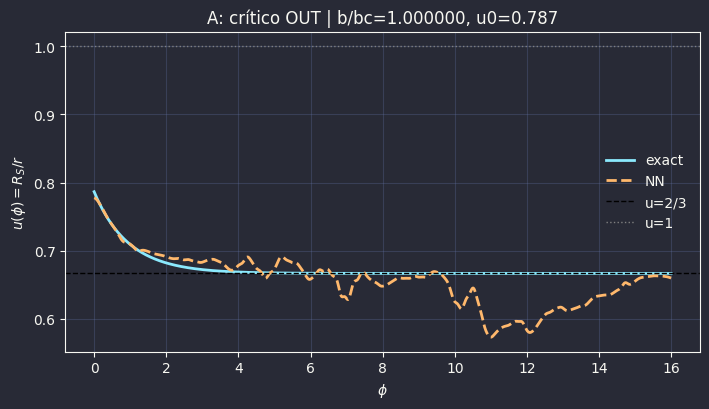

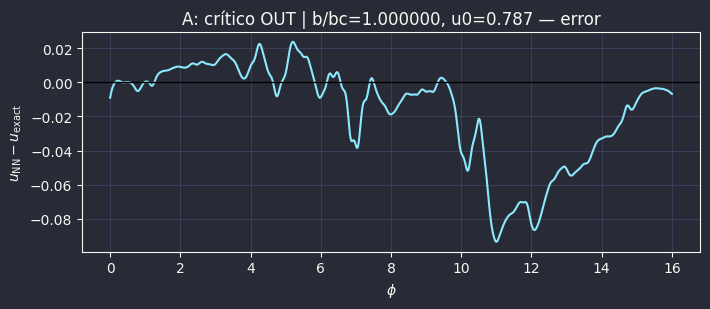

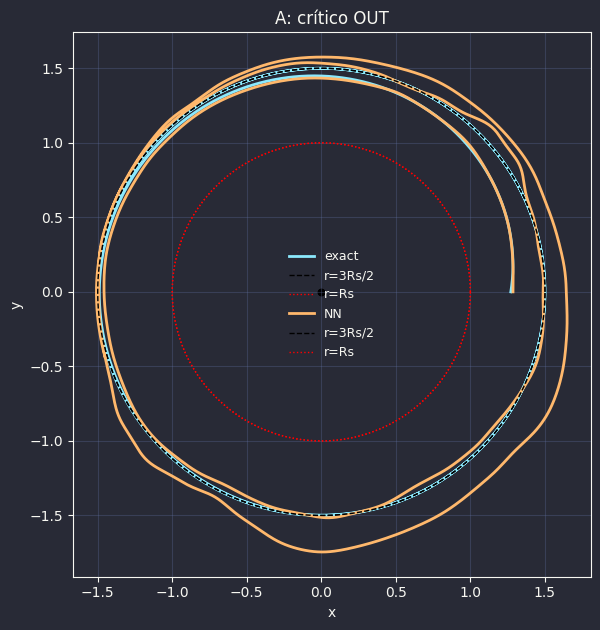

A: crítico IN | b/bc=1.000000, u0=0.547
  points used: 2000/2000
  MAE  = 3.0285e-02
  RMSE = 4.0162e-02
  mean |err|/|u| = 4.5494e-02


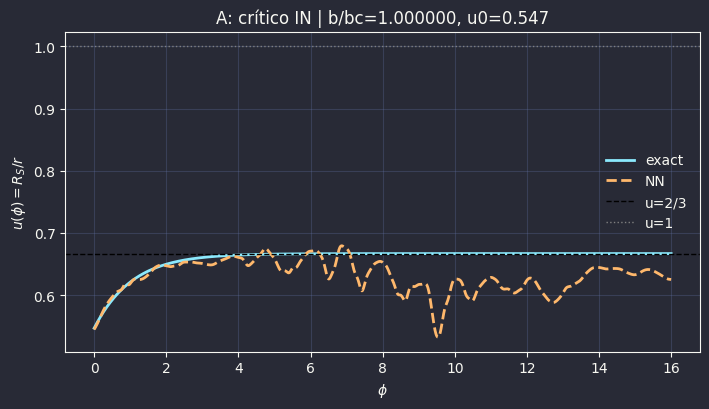

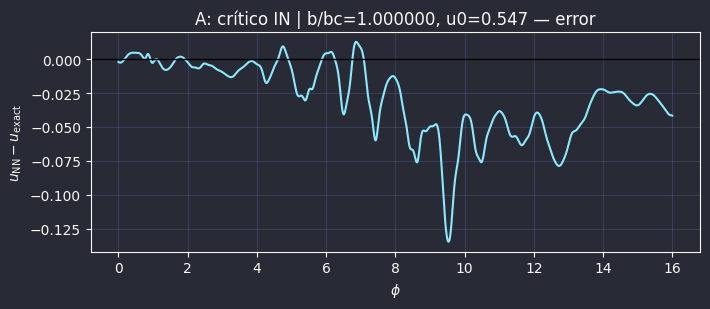

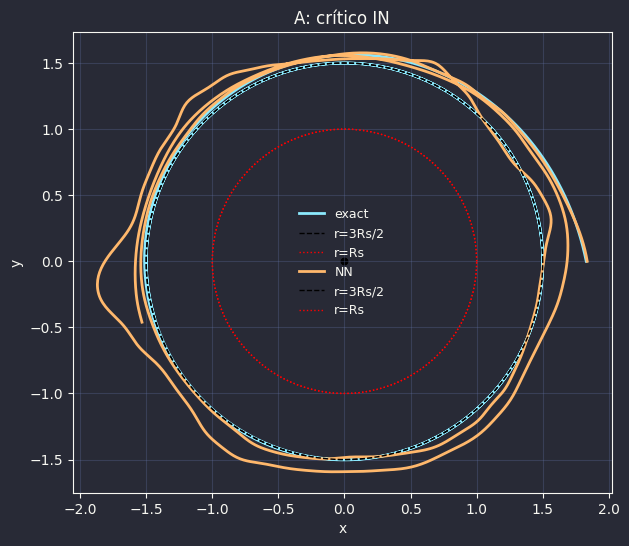

B: subcrítico incoming | b/bc=0.980000, u0=0.400
  points used: 1172/2000
  MAE  = 1.1845e-02
  RMSE = 1.4559e-02
  mean |err|/|u| = 8.4184e-02


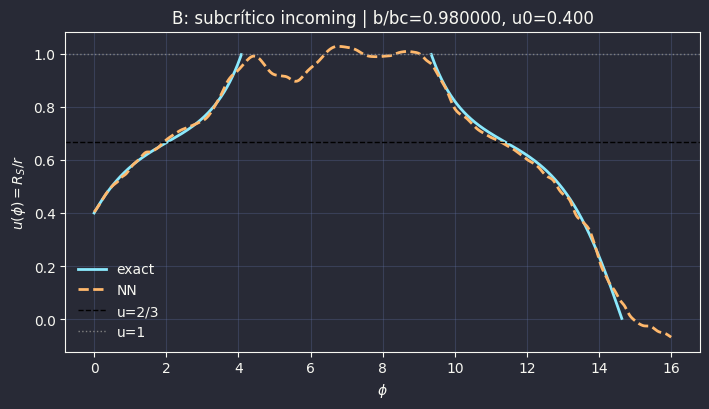

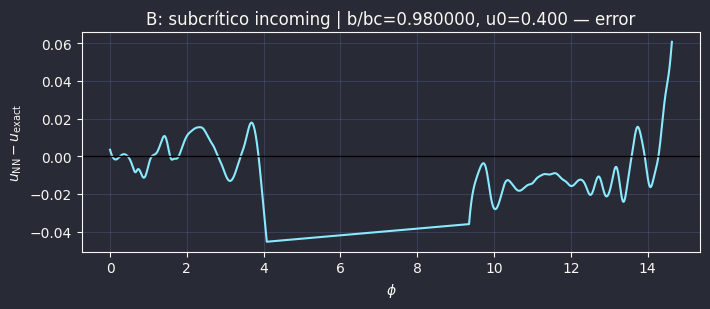

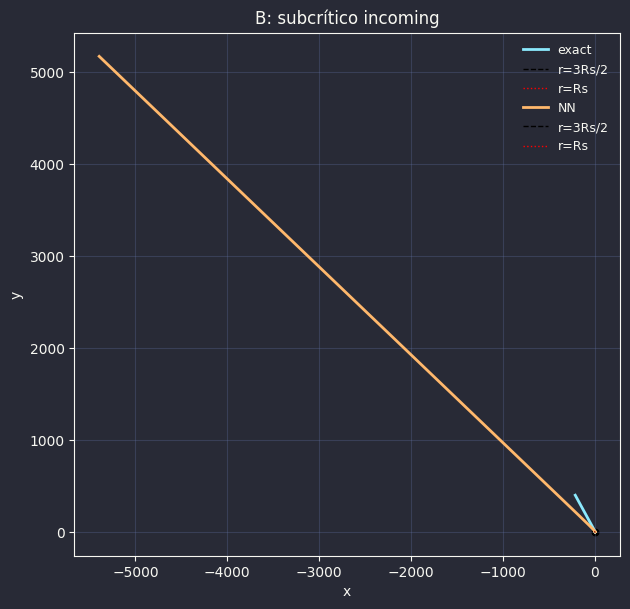

B: subcrítico outgoing | b/bc=0.980000, u0=0.850
  points used: 1259/2000
  MAE  = 1.5623e-02
  RMSE = 1.9209e-02
  mean |err|/|u| = 1.2450e-01


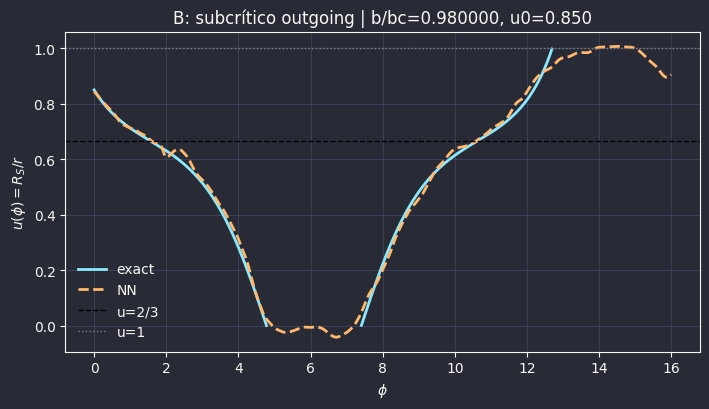

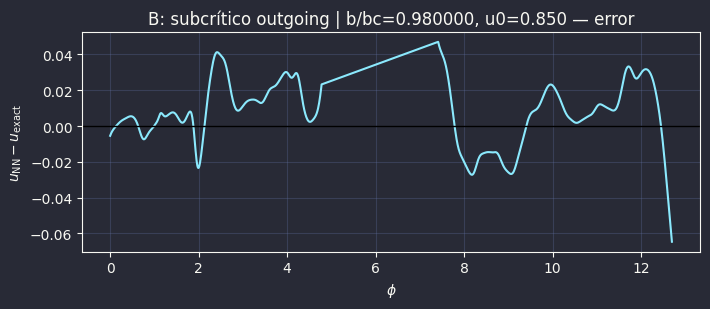

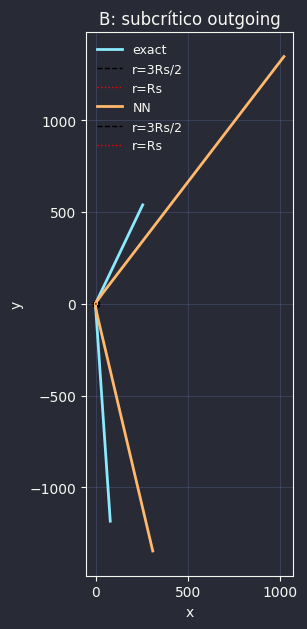

C: supercrítico scatter | b/bc=1.004000, u0=0.150
  points used: 1671/2000
  MAE  = 4.2049e-02
  RMSE = 5.7597e-02
  mean |err|/|u| = 5.5446e-01


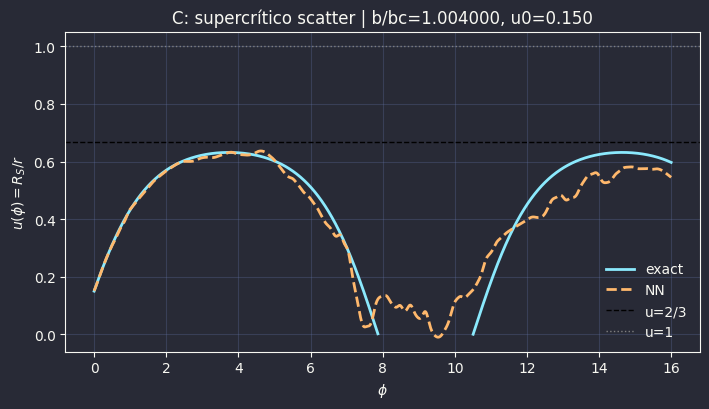

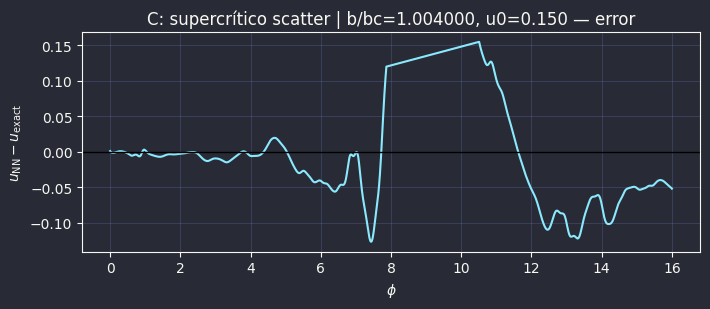

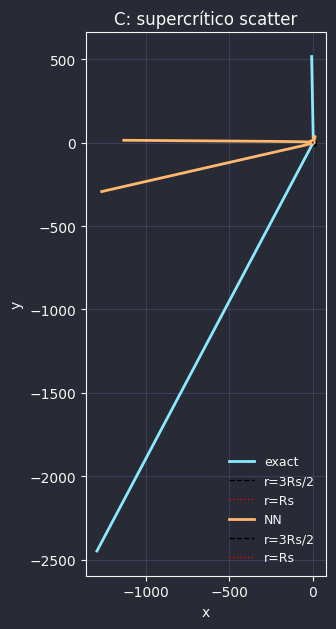

Random 0 | tag=C, b/bc=1.000212, u0=0.910
  points used: 1341/2000
  MAE  = 6.9795e-02
  RMSE = 1.2530e-01
  mean |err|/|u| = 8.4468e-02


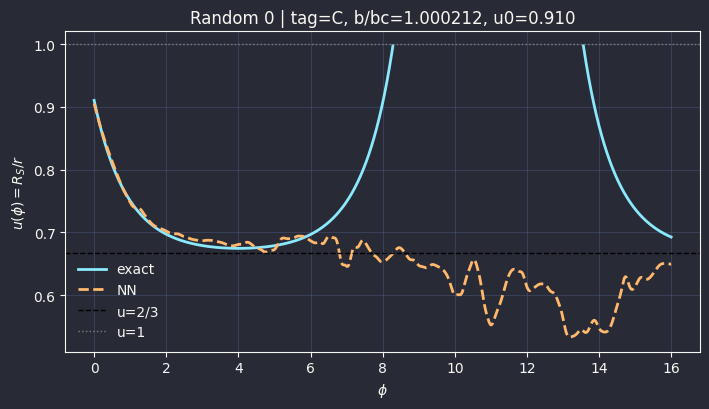

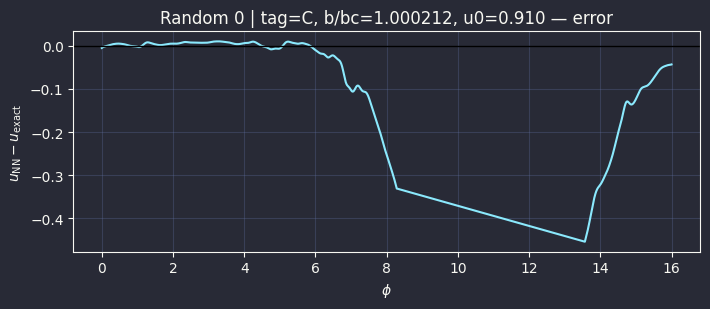

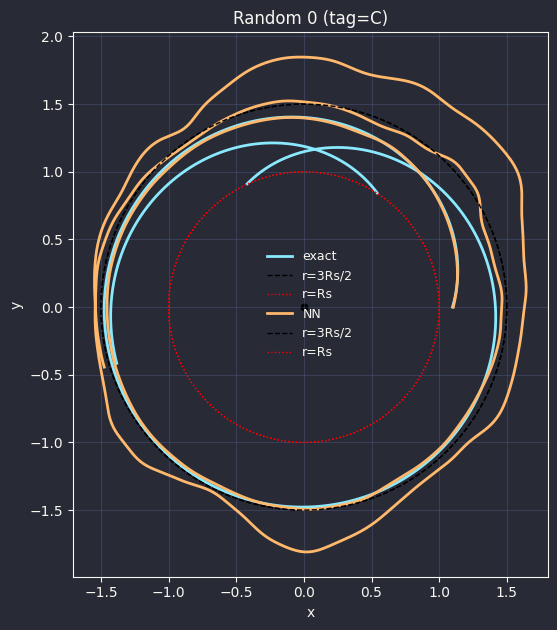

Random 1 | tag=A, b/bc=1.000000, u0=0.667
  points used: 2000/2000
  MAE  = 3.3969e-03
  RMSE = 4.8270e-03
  mean |err|/|u| = 5.0953e-03


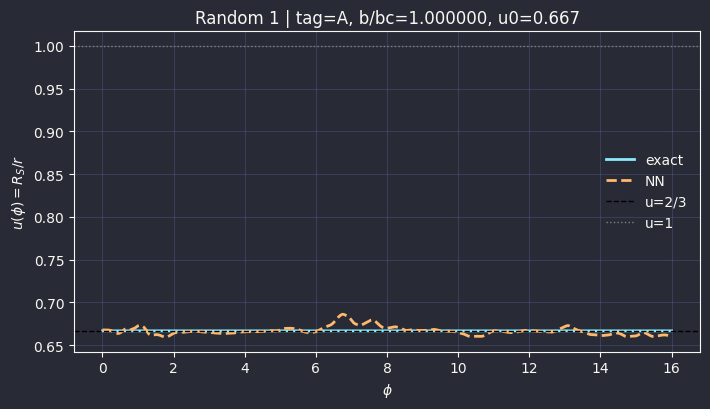

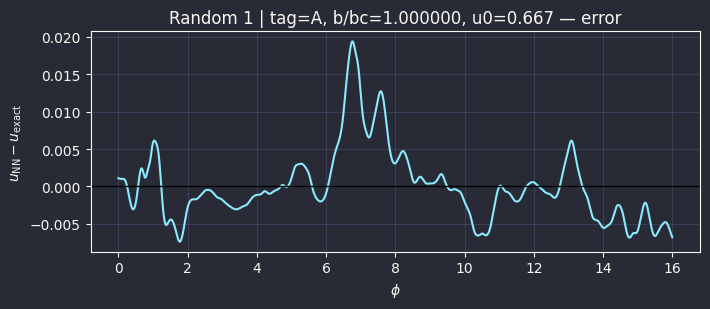

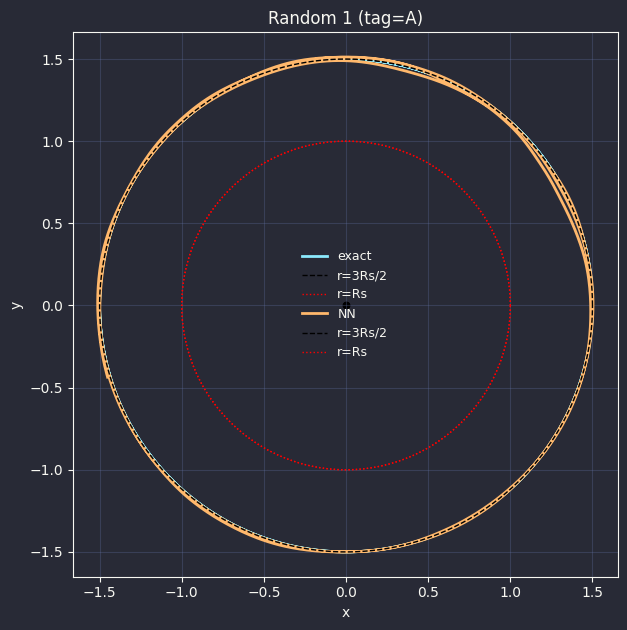

Random 2 | tag=C, b/bc=1.014660, u0=0.284
  points used: 1647/2000
  MAE  = 1.0520e-02
  RMSE = 1.5815e-02
  mean |err|/|u| = 1.8777e-01


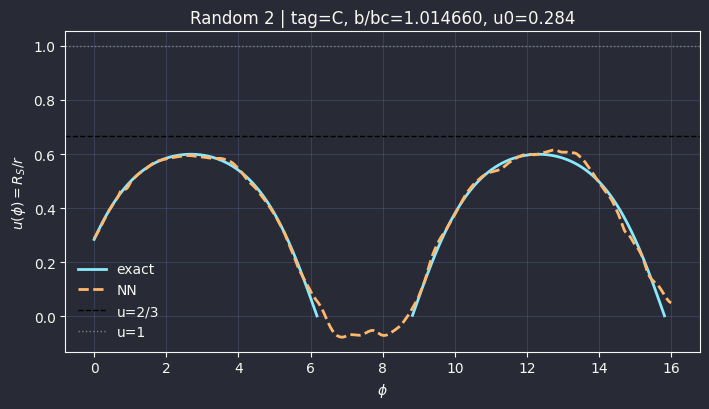

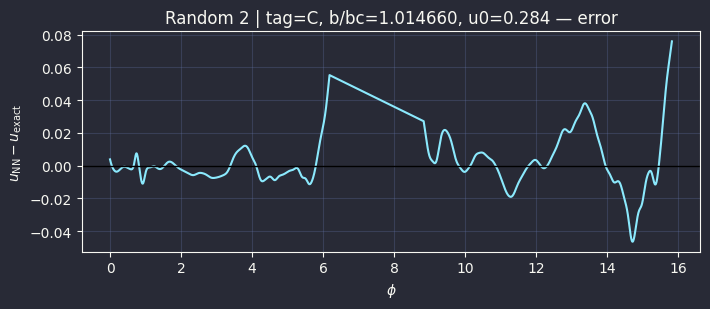

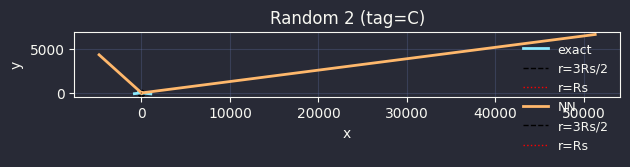


Resumen random suite:
  mean MAE  = 3.4277e-02  (std 2.3018e-02)
  mean RMSE = 5.7841e-02 (std 4.2746e-02)


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotx
plt.style.use(matplotx.styles.dracula)
# -----------------------------
# Helpers: features + predicción
# -----------------------------
def make_features(phi, u0, b, Rs=1.0, K=8):
    """
    Construye X_test con el mismo formato del training:
    X = [phi, u0, b/bc, sin(k phi), cos(k phi)] k=1..K
    """
    bc = bcrit(Rs)
    phi = np.asarray(phi, dtype=np.float32)
    uu0 = np.full_like(phi, u0, dtype=np.float32)
    bb  = np.full_like(phi, b/bc, dtype=np.float32)

    pe = []
    for k in range(1, K+1):
        pe.append(np.sin(k*phi))
        pe.append(np.cos(k*phi))
    pe = np.stack(pe, axis=1).astype(np.float32)

    X = np.concatenate([phi[:,None], uu0[:,None], bb[:,None], pe], axis=1).astype(np.float32)
    return X

@torch.no_grad()
def predict_u(model, phi, u0, b, Rs=1.0, K=8):
    X = make_features(phi, u0, b, Rs=Rs, K=K)
    device = next(model.parameters()).device
    up = model(torch.tensor(X, device=device)).detach().cpu().numpy().squeeze()
    return up

# -----------------------------
# Métricas y plots
# -----------------------------
def trajectory_report(model, phi, u_true, u_pred, title=""):
    mask = np.isfinite(u_true) & np.isfinite(u_pred)
    if mask.sum() < 10:
        print("[WARN] muy pocos puntos finitos para evaluar.")
        return

    err = u_pred[mask] - u_true[mask]
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    rel = np.mean(np.abs(err) / np.maximum(np.abs(u_true[mask]), 1e-6))

    print(f"{title}")
    print(f"  points used: {mask.sum()}/{len(phi)}")
    print(f"  MAE  = {mae:.4e}")
    print(f"  RMSE = {rmse:.4e}")
    print(f"  mean |err|/|u| = {rel:.4e}")

    # u(phi)
    plt.figure(figsize=(7.2,4.2))
    plt.plot(phi, u_true, lw=2, label="exact")
    plt.plot(phi, u_pred, "--", lw=2, label="NN")
    plt.axhline(2/3, ls="--", c="k", lw=1, label="u=2/3")
    plt.axhline(1.0, ls=":",  c="gray", lw=1, label="u=1")
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"$u(\phi)=R_S/r$")
    plt.title(title)
    plt.grid(True, alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # error(phi)
    plt.figure(figsize=(7.2,3.2))
    plt.plot(phi[mask], err, lw=1.5)
    plt.axhline(0.0, c="k", lw=1)
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"$u_{\rm NN}-u_{\rm exact}$")
    plt.title(title + " — error")
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

def plot_orbit_xy(phi, u, Rs=1.0, ax=None, label=None, lw=2):
    """
    Convierte u -> r y plotea órbita en (x,y). Maneja nan.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2,6.2))
    r = np.where(np.isfinite(u) & (u>0), Rs/u, np.nan)
    x, y = r*np.cos(phi), r*np.sin(phi)
    ax.plot(x, y, lw=lw, label=label)
    ax.scatter([0],[0], s=20, c="k")

    th = np.linspace(0, 2*np.pi, 400)
    ax.plot(1.5*Rs*np.cos(th), 1.5*Rs*np.sin(th), "--", c="k", lw=1, label="r=3Rs/2")
    ax.plot(Rs*np.cos(th),     Rs*np.sin(th),     ":",  c="r", lw=1, label="r=Rs")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.grid(True, alpha=.3)
    return ax

def orbit_compare_plot(phi, u_true, u_pred, Rs=1.0, title=""):
    fig, ax = plt.subplots(figsize=(6.4,6.4))
    plot_orbit_xy(phi, u_true, Rs=Rs, ax=ax, label="exact", lw=2)
    plot_orbit_xy(phi, u_pred, Rs=Rs, ax=ax, label="NN", lw=2)
    ax.set_title(title)
    ax.legend(fontsize=9, loc="best")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 1) Pruebas “curadas” (A/B/C)
# -----------------------------
Rs = 1.0
bc = bcrit(Rs)

phi = np.linspace(1e-4, 16.0, 2000).astype(np.float32)

tests = [
    ("A: crítico OUT",          bc,        2/3 + 0.12),
    ("A: crítico IN",           bc,        2/3 - 0.12),
    ("B: subcrítico incoming",  0.98*bc,   0.40),
    ("B: subcrítico outgoing",  0.98*bc,   0.85),
    ("C: supercrítico scatter", 1.004*bc,  0.15),
]

for name, b, u0 in tests:
    u_true, meta = u_phi_general(phi, Rs=Rs, b=b, u0=u0)
    u_pred = predict_u(model, phi, u0, b, Rs=Rs, K=8)

    trajectory_report(model, phi, u_true, u_pred, title=f"{name} | b/bc={b/bc:.6f}, u0={u0:.3f}")
    orbit_compare_plot(phi, u_true, u_pred, Rs=Rs, title=name)

# -----------------------------
# 2) “Stress test” random (varias trayectorias)
# -----------------------------
def random_test_suite(model, N=8, Rs=1.0, phi_max=16.0, T=2000, K=8, seed=0):
    rng = np.random.default_rng(seed)
    phi = np.linspace(1e-4, phi_max, T).astype(np.float32)

    maes, rmses = [], []
    for i in range(N):
        b, tag = sample_b(Rs=Rs, rng=rng)
        u0 = sample_u0_for_case(b, tag, Rs=Rs, rng=rng)
        u_true, _ = u_phi_general(phi, Rs=Rs, b=b, u0=u0)
        u_pred = predict_u(model, phi, u0, b, Rs=Rs, K=K)

        mask = np.isfinite(u_true) & np.isfinite(u_pred)
        if mask.sum() < 50:
            continue
        err = u_pred[mask] - u_true[mask]
        mae = np.mean(np.abs(err))
        rmse = np.sqrt(np.mean(err**2))
        maes.append(mae); rmses.append(rmse)

        # plotea 1 de cada ~N/2
        if i < min(3, N):
            trajectory_report(model, phi, u_true, u_pred, title=f"Random {i} | tag={tag}, b/bc={b/bcrit(Rs):.6f}, u0={u0:.3f}")
            orbit_compare_plot(phi, u_true, u_pred, Rs=Rs, title=f"Random {i} (tag={tag})")

    if len(maes) > 0:
        print("\nResumen random suite:")
        print(f"  mean MAE  = {np.mean(maes):.4e}  (std {np.std(maes):.4e})")
        print(f"  mean RMSE = {np.mean(rmses):.4e} (std {np.std(rmses):.4e})")
    else:
        print("No se pudieron evaluar trayectorias random (mascara demasiado estricta o casos raros).")

random_test_suite(model, N=10, Rs=1.0, phi_max=16.0, T=2000, K=8, seed=42)


Keys in ckpt: ['model', 'optimizer', 'epoch', 'best_val_loss', 'train_hist', 'val_hist', 'lr_hist', 'lambda_pinn', 'init_lr', 'batch', 'seed'] ...
Has train_hist? True
Has val_hist? True
Has lr_hist? True


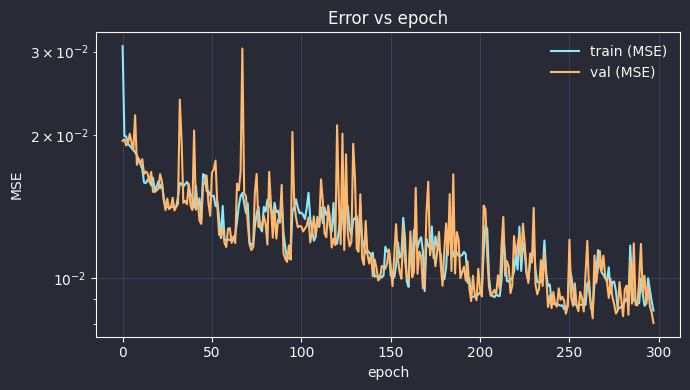

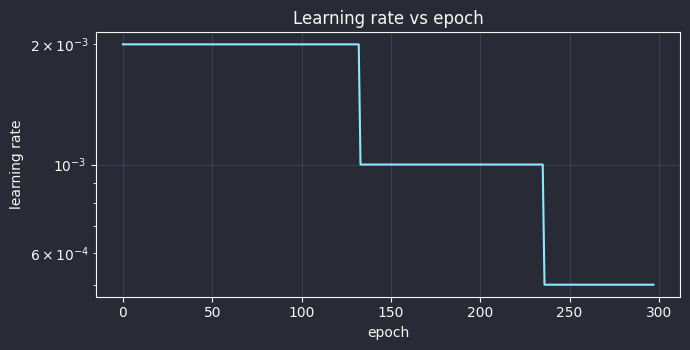

No encontré pinn_hist en el checkpoint. Si quieres verla, hay que guardarla durante el training.


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

ckpt_path = "best_orbit_emulator.pt"  # cambia si tu nombre es distinto
ckpt = torch.load(ckpt_path, map_location="cpu")

# Intenta extraer historias comunes (según cómo guardaste el ckpt)
train_hist = ckpt.get("train_hist", None)
val_hist   = ckpt.get("val_hist", None)
lr_hist    = ckpt.get("lr_hist", None)

# Opcionales (si los guardaste)
pinn_hist  = ckpt.get("pinn_hist", None)          # por ejemplo
train_pinn = ckpt.get("train_pinn_hist", None)    # otro nombre posible
val_pinn   = ckpt.get("val_pinn_hist", None)

print("Keys in ckpt:", list(ckpt.keys())[:30], "...")
print("Has train_hist?", train_hist is not None)
print("Has val_hist?", val_hist is not None)
print("Has lr_hist?", lr_hist is not None)

# ---- Plot train/val MSE
if train_hist is not None or val_hist is not None:
    plt.figure(figsize=(7,4))
    if train_hist is not None:
        plt.plot(train_hist, label="train (MSE)")
    if val_hist is not None:
        plt.plot(val_hist, label="val (MSE)")
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.title("Error vs epoch")
    plt.grid(True, alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Plot LR schedule
if lr_hist is not None:
    plt.figure(figsize=(7,3.6))
    plt.plot(lr_hist)
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.title("Learning rate vs epoch")
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

# ---- Plot PINN loss (si existe)
# (Usa el primero que encuentre)
p = None
label = None
for cand, lab in [(pinn_hist,"pinn_hist"),
                  (train_pinn,"train_pinn_hist"),
                  (val_pinn,"val_pinn_hist")]:
    if cand is not None:
        p, label = cand, lab
        break

if p is not None:
    plt.figure(figsize=(7,3.6))
    plt.plot(p)
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("PINN residual loss")
    plt.title(f"PINN loss vs epoch ({label})")
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()
else:
    print("No encontré pinn_hist en el checkpoint. Si quieres verla, hay que guardarla durante el training.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
save_path = "/content/drive/MyDrive/orbit_emulator_schwarzschild.pt"
torch.save(model.state_dict(), save_path)
print(f"Modelo guardado en: {save_path}")
